We live in the world of e-commerce. We see tons of different stores here and there through the web. Internet made it possible to trade with anyone and everywhere. We can buy goods without leaving our house, we can compare prices in different stores within seconds, we can find what we really want and do not accept just the first more or less suitable offer. And I believe it would be really interesting to look at this world through the data it produces. That's why I decided to play around with e-commerce numbers and try to understand it better.

The data used in this analysis is taken from Kaggle dataset ["E-Commerce Data | Actual transactions of UK retailer"](https://www.kaggle.com/carrie1/ecommerce-data). 

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

As always, we start our analysis by setting up our environment and by importing necessary libraries.

We import standard numpy and pandas to be able to perform analysis with Python, also we need data visualization libraries matplotlib and seaborn to output interesting visual findings, aaaaand some settings to make our kernel prettier.

# 1. Import libraries and data

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

We import our data using *.read_csv()* method and we also add a parameter "encoding='latin'" as default encoding engine wasn't able to process this particular dataset. So next time you have difficulties importing data and everything seems to be correct and OK, check out encoding. That might save you some time of googling to try to understand what's wrong.

In [97]:
df = pd.read_csv('data.csv', encoding='latin')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Just by looking at first 5 rows of our table we can understand the structure and datatypes present in our dataset. We can notice that we will have to deal with timeseries data, integers and floats, categorical and text data.

In [98]:
# df = []
# while(1):
#     df.append('1')

# 2. Exploratory data analysis

Every data science project starts with EDA as we have to understand what do we have to deal with. I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple pndas method *.describe()* gives us a lot of useful information.

## 2.1. Quick statistical overview

In [99]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,37309.000000,37308.000000,24429.000000
mean,8.011901,6.230193,15540.025339
std,61.414804,148.693371,1731.742013
min,-9360.000000,0.000000,12347.000000
25%,1.000000,1.280000,14210.000000
50%,2.000000,2.510000,15570.000000
75%,7.000000,4.250000,17158.000000
max,2880.000000,13541.330000,18269.000000


Just a quick look at data with *.describe()* method gives us a lot of space to think. We see negative quantities and prices, we can see that not all records have CustomerID data, we can also see that the majority of transactions are for quantites from 3 to 10 items, majority of items have price up to 5 pounds and that we have a bunch of huge outliers we will have to deal with later.

## 2.2. Dealing with types

*.read_csv()* method performs basic type check, but it doesn't do that perfectly. That's why it is much better to deal with data types in our dataframe before any modifications to prevent additional difficulties. Every pandas dataframe has an attribute *.dtypes* which will help us understand what we currently have and what data has to be casted to correct types.

In [100]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

If we have datetime data it's better to cast it to datetime type. We don't touch InvoiceNo for now as it seems like data in this column has not only numbers. (we saw just first 5 rows, while pandas during import scanned all the data and found that the type here is not numerical).

In [101]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

## 2.3. Dealing with null values

Next and very important step is dealing with missing values. Normally if you encounter null values in the dataset you have to understand nature of those null values and possible impact they could have on the model. There are few strategies that we can use to fix our issue with null values: 
* delete rows with null values
* delete the feature with null values
* impute data with mean or median values or use another imputing strategy (method *.fillna()*)

Let's check out what we have here.

In [102]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      117
Quantity           0
UnitPrice          1
CustomerID     12880
Country            1
dtype: int64

CustomerID has too much null values and this feature cannot predict a lot so we can just drop it. Also it could be reasonable to create another feature "Amount of orders per customer", but.... next time ;)

In [103]:
df = df.drop(columns=['CustomerID'])

Let's check out what kind of nulls we have in Description

In [104]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales. I think, we can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [105]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      1
Country        1
dtype: int64

## 2.4. Checking out columns separately

Also it makes sense to go feature by feature and check what pitfalls we have in our data and also to understand our numbers better. 

Let's continue checking Description column. Here we can see items that were bought most often. 

In [106]:
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    215
PAPER CHAIN KIT 50'S CHRISTMAS        166
REGENCY CAKESTAND 3 TIER              162
HAND WARMER BABUSHKA DESIGN           145
SCOTTIE DOG HOT WATER BOTTLE          137
Name: Description, dtype: int64

Here we can see our best selling products, items that appear in orders the most often. Also to make it visually more appealing let's create a bar chart for 15 top items.

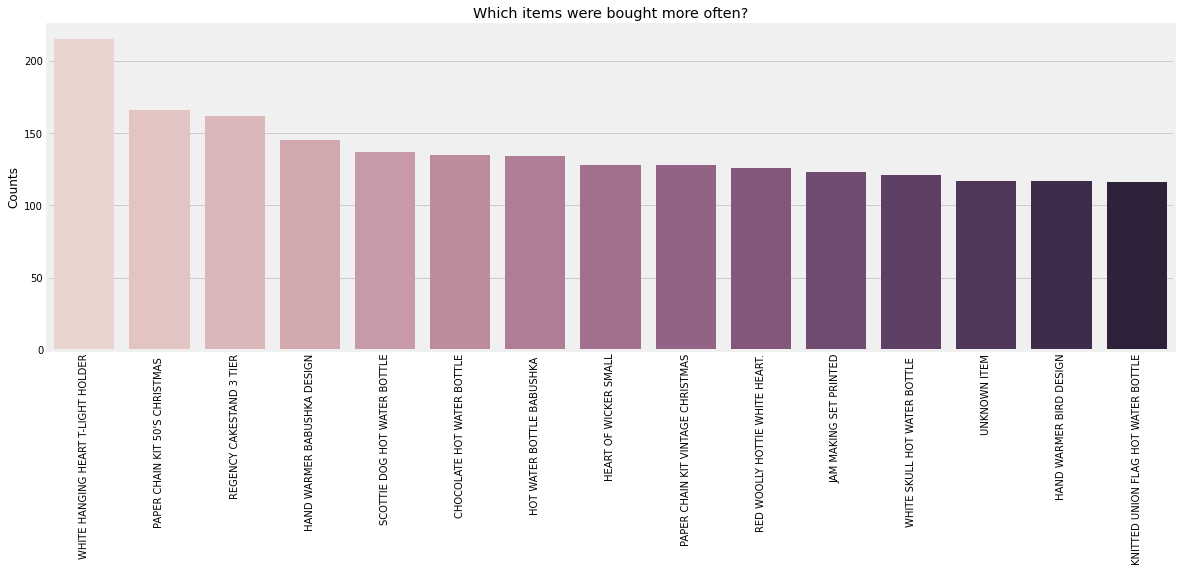

In [107]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [108]:
df['Description'].value_counts().tail()

SUNJAR LED NIGHT NIGHT LIGHT         1
LETTER "O" BLING KEY RING            1
DROP EARRINGS W FLOWER & LEAF        1
BUTTERFLY HAIR BAND                  1
PURPLE CHUNKY GLASS+BEAD NECKLACE    1
Name: Description, dtype: int64

We also notice from above code that valid items are normally uppercased and non-valid or cancelations are in lower case

In [109]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Manual                                35
BAG 250g SWIRLY MARBLES               25
BAG 125g SWIRLY MARBLES               16
3 TRADITIONAl BISCUIT CUTTERS  SET    13
BAG 500g SWIRLY MARBLES               12
Name: Description, dtype: int64

Quick check of the case of letters in Description says that there are some units with lower case letters in their name and also that lower case records are for canceled items. Here we can understand that data management in the store can be improved.

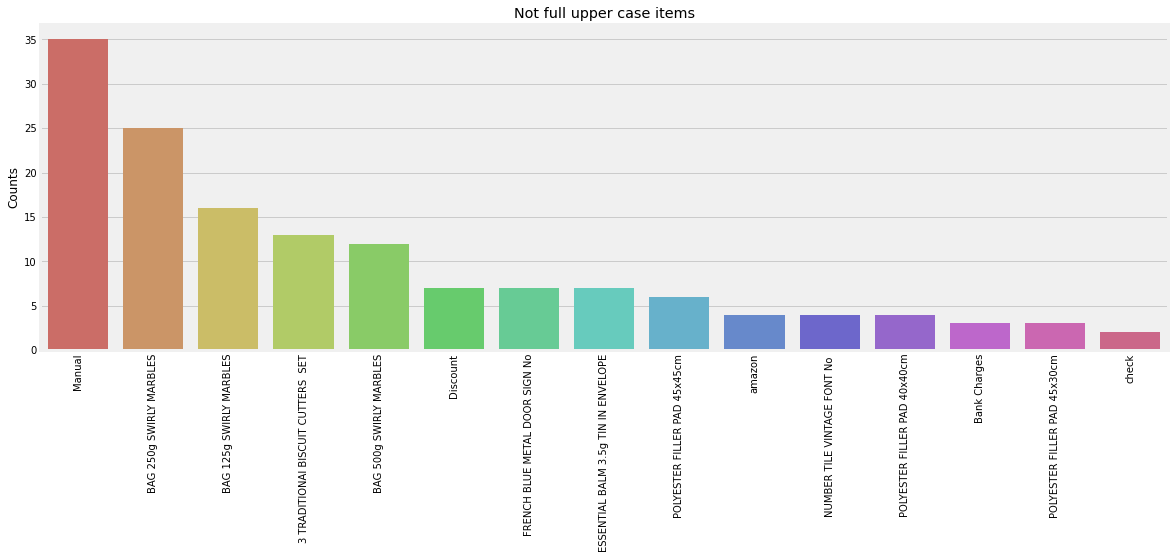

In [110]:
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(lcase_counts.index, lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

ALso checking out stoke codes, looks like they are deeply correlated with descriptions - which makes perfect sense.

In [111]:
df['StockCode'].value_counts().head()

85123A    211
22086     166
22423     163
22834     145
22111     137
Name: StockCode, dtype: int64

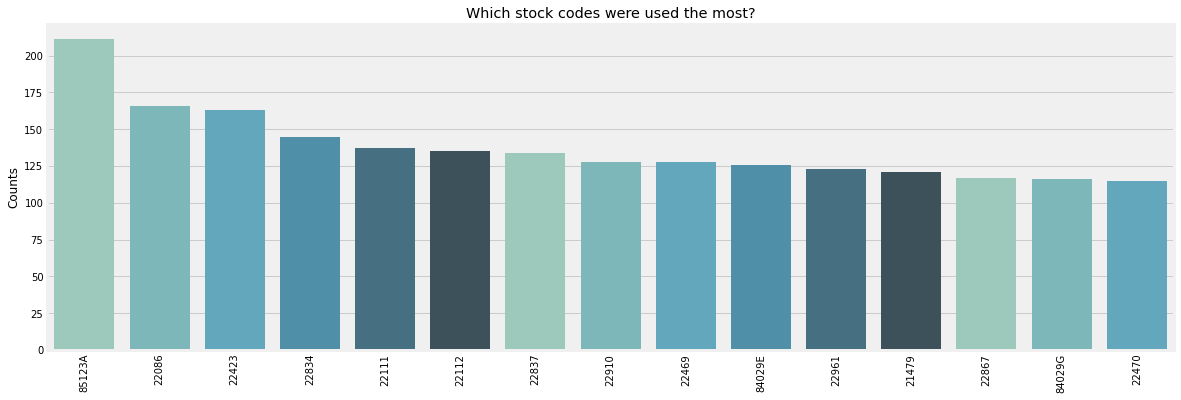

In [112]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(stock_counts.index, stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

Checking out also InvoiceNo feature.

In [113]:
df['InvoiceNo'].value_counts().tail()

538041     1
538042     1
C538813    1
538043     1
538188     1
Name: InvoiceNo, dtype: int64

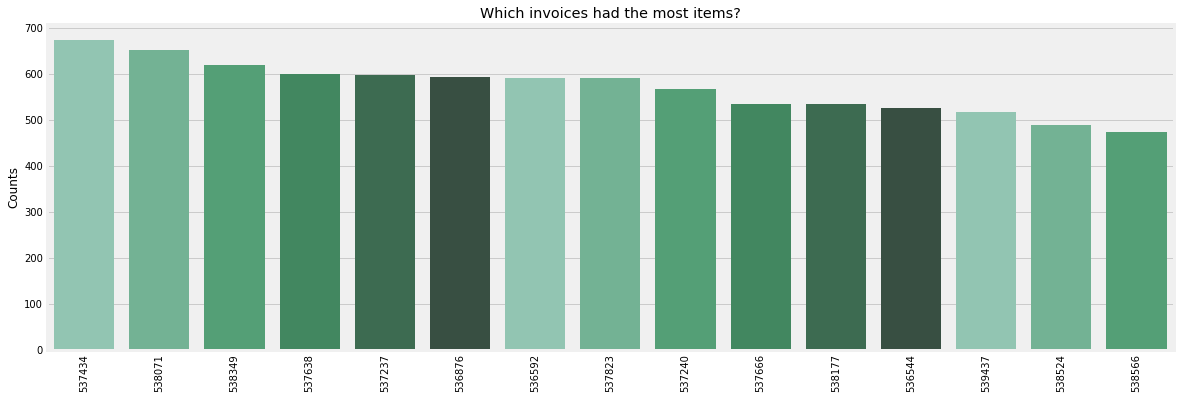

In [114]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(inv_counts.index, inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [115]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,596.000000,596.000000
mean,-25.046980,100.871510
std,384.357534,1021.463454
min,-9360.000000,0.030000
25%,-6.000000,1.650000
50%,-2.000000,2.950000
75%,-1.000000,7.125000
max,-1.000000,13541.330000


Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mistery with negative quantities. 

Although, we should've gotten deeper into analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.

We can actually start a separate project based on that data and predict the returning/cancelling rates for the store.

In [116]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [117]:
df.describe()

,Quantity,UnitPrice
count,36713.000000,36712.000000
mean,8.548580,4.693741
std,37.691831,73.552725
min,-723.000000,0.000000
25%,1.000000,1.280000
50%,2.000000,2.510000
75%,8.000000,4.250000
max,2880.000000,13541.330000


During exploratory data analysis we can go back to the same operations and checks, just to understand how our actions affected the dataset. EDA is the series of repetitive tasks to understand better our data. And here, for example we get back to *.describe()* method to get an overall picture of our data after some manipulations. 

We still see negative quantities and negative prices, let's get into those records.



In [118]:
# df[df['Quantity'] < 0]
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


Here we can see that other "Negative quantities" appear to be damaged/lost/unknown items. Again, we will just ignore them for the sake of simplicity of analysis for this project.

In [119]:
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,36644.000000,36643.000000
mean,8.674108,4.702579
std,37.373918,73.621663
min,1.000000,0.000000
25%,1.000000,1.280000
50%,2.000000,2.510000
75%,8.000000,4.250000
max,2880.000000,13541.330000


We also see negative UnitPrice, which is not normal as well. Let's check this out.

In [120]:
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [121]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,


As there are just two rows, let's ignore them for the moment (description gives us enough warnings, althoug we still need some context to understand it better)

In [122]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,36518.000000,36518.000000
mean,8.647982,4.718676
std,37.309528,73.747046
min,1.000000,0.070000
25%,1.000000,1.450000
50%,2.000000,2.510000
75%,8.000000,4.250000
max,2880.000000,13541.330000


As we have finished cleaning our data and removed all suspicious records we can start creating some new features for our model. Let's start with the most obvious one - Sales. We have quantities, we have prices - we can calculate the revenue.

In [123]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


# 3. Visual EDA

(array([0]), <a list of 1 Text major ticklabel objects>)

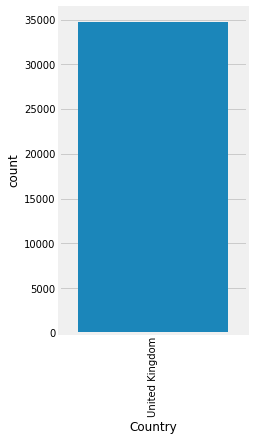

In [124]:
plt.figure(figsize=(3,6))
sns.countplot(df[df['Country'] == 'United Kingdom']['Country'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text major ticklabel objects>)

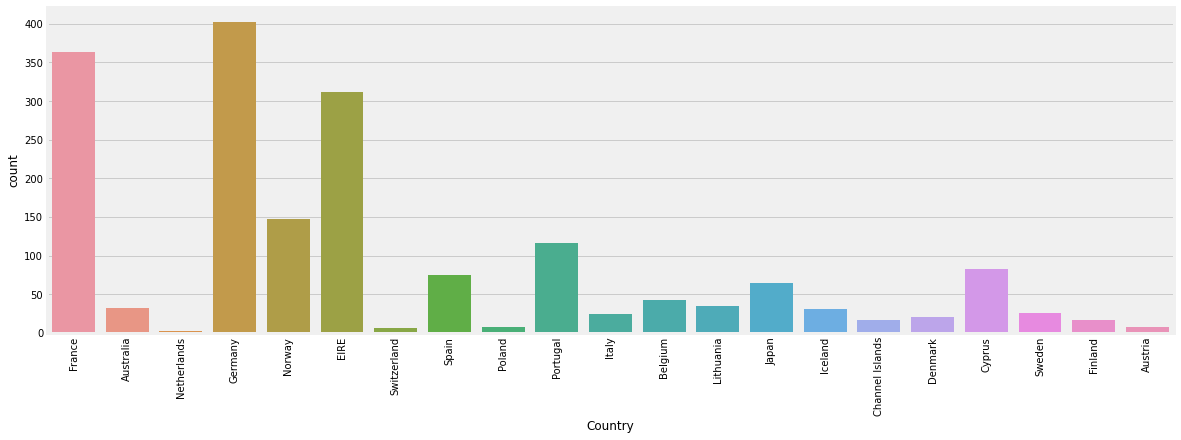

In [125]:
plt.figure(figsize=(18,6))
sns.countplot(df[df['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

In [126]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

94.99%


From above plots and calculations we can see that vast majority of sales were made in UK and just 8.49% went abroad. We can say our dataset is skewed to the UK side :D.

## 3.1. Detecting outliers

There are few different methods to detect outliers: box plots, using [IQR](https://en.wikipedia.org/wiki/Interquartile_range), scatter plot also works in some cases (and this is one of those). Also, detecting outliers using scatter plot is pretty intuitive. You plot your data and remove data points that visually are definitely out of range. Like in the chart below.

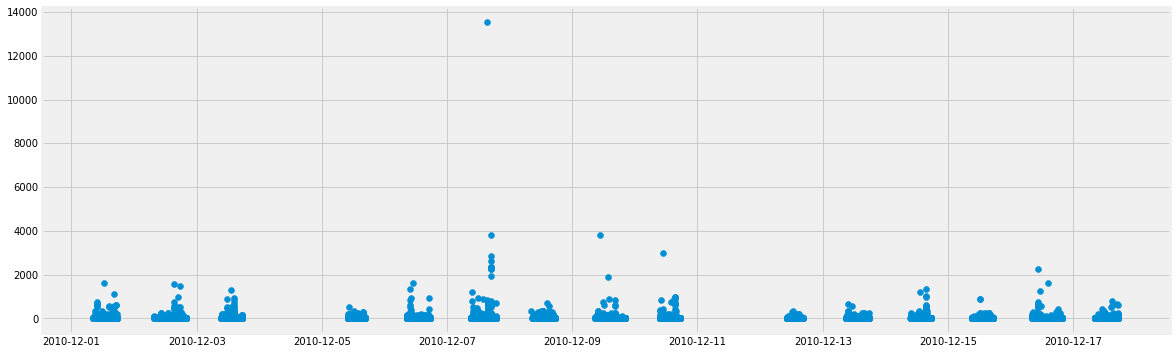

In [127]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])

Let's remove obvious outliers

(array([734107., 734109., 734111., 734113., 734115., 734117., 734119.,
        734121., 734123.]), <a list of 9 Text major ticklabel objects>)

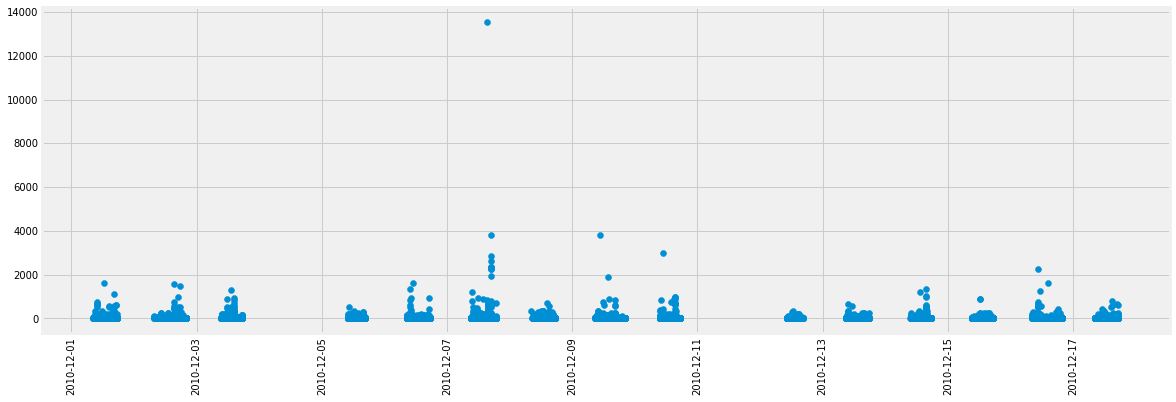

In [128]:
df = df[df['Sales'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])
plt.xticks(rotation=90)

After removing obvious outliers we still see some values that are out of normal distribution. To understand better the distribution of our data let's check out different percentiles of our numeric features. 

In [129]:
df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,Sales
0.050,1.000,0.55000,1.25000
0.950,24.000,11.02000,59.70000
0.980,48.000,16.13000,107.10000
0.990,96.000,20.38000,178.14390
0.999,400.966,155.61645,900.03214


We can see that if we remove top 2% of our data points we will get rid of absolute outliers and will have more balaced dataset.

(array([734107., 734109., 734111., 734113., 734115., 734117., 734119.,
        734121., 734123.]), <a list of 9 Text major ticklabel objects>)

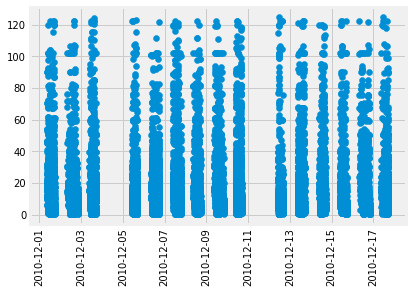

In [130]:
df_quantile = df[df['Sales'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['Sales'])
plt.xticks(rotation=90)

In [131]:
df_quantile.describe()

,Quantity,UnitPrice,Sales
count,35893.000000,35893.000000,35893.000000
mean,6.657733,3.705377,13.809064
std,13.286949,4.013669,16.854744
min,1.000000,0.070000,0.140000
25%,1.000000,1.280000,3.480000
50%,2.000000,2.510000,8.420000
75%,6.000000,4.250000,16.980000
max,720.000000,121.060000,124.950000


Looks like our data is almost ready for modelling. We performed a clean up, we removed outliers that were disturbing the balance of our dataset, we removed invalid records - now our data looks much better! and it doesn't lose it's value.

## 3.2. Visually checking distribution of numeric features

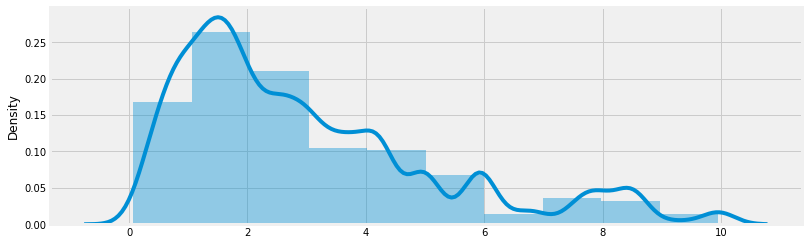

In [132]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

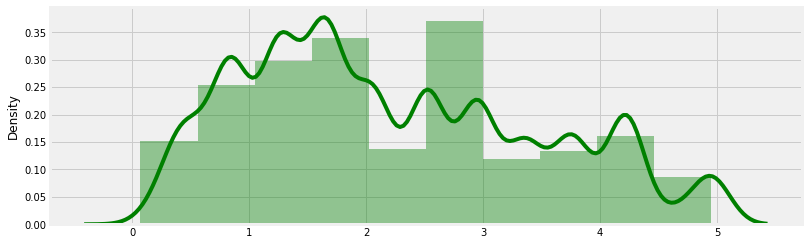

In [133]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')

From these histograms we can see that vast majority of items sold in this store has low price range - 0 to 3 pounds. 

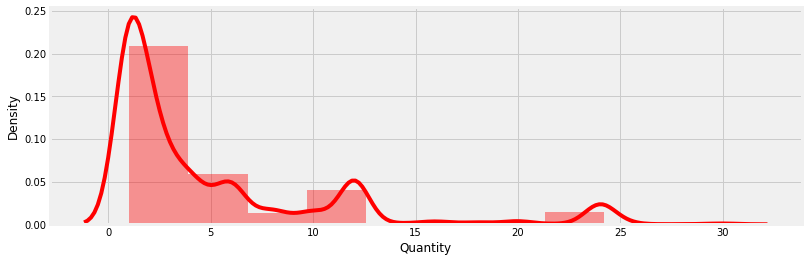

In [134]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

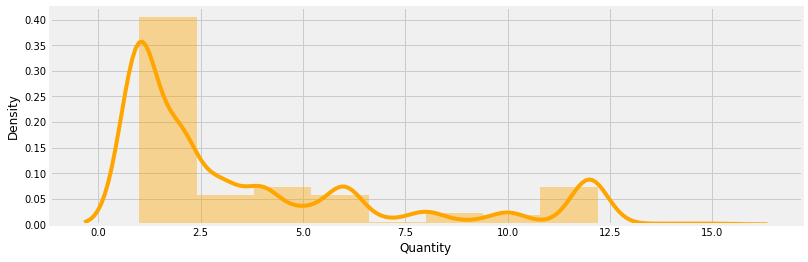

In [135]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

From these histograms we that people bought normally 1-5 items or 10-12 - maybe there were some kind of offers for sets?

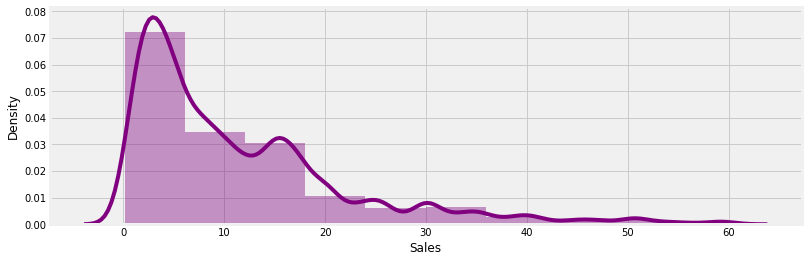

In [136]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 60]['Sales'], kde=True, bins=10, color='purple')

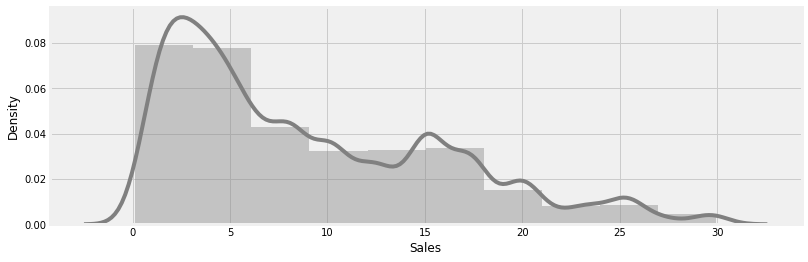

In [137]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 30]['Sales'], kde=True, bins=10, color='grey')

From these histograms we can understand that majority of sales per order were in range 1-15 pounds each.

## 3.3. Analysing sales over time

In [138]:
df_ts = df[['Sales']]
df_ts.head()

,Sales
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


As we can see every invoice has it's own timestamp (definitely based on time the order was made). We can resample time data by, for example weeks, and try see if there is any patterns in our sales.

<Figure size 1296x432 with 0 Axes>

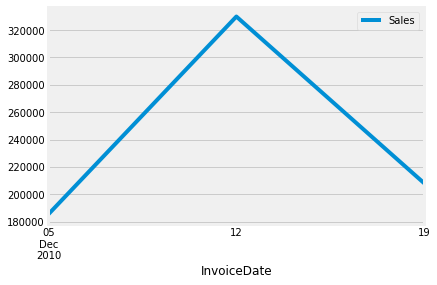

In [139]:
plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

That week with 0 sales in January looks suspicious, let's check it closer

In [140]:
df_resample['12-2010':'01-2011']

,Sales
InvoiceDate,
2010-12-05,185427.83
2010-12-12,329936.81
2010-12-19,208013.05


Now it makes sense - possibly, during the New Year holidays period the store was closed and didn't process orders, that's why they didn't make any sales.

# 4. Preparing data for modeling and feature creation

Now it comes the most fun part of the project - building a model. To do this we will need to create few more additional features to make our model more sophisticated.

In [141]:
df_clean = df[df['UnitPrice'] < 15]
df_clean.describe()

,Quantity,UnitPrice,Sales
count,35725.000000,35725.000000,35725.000000
mean,8.795353,3.349619,18.217557
std,37.699988,2.785138,66.084362
min,1.000000,0.070000,0.140000
25%,1.000000,1.280000,3.480000
50%,3.000000,2.510000,8.420000
75%,8.000000,4.210000,17.000000
max,2880.000000,14.950000,3828.000000


In [142]:
df_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2010-12-17 17:23:00', '2010-12-17 17:23:00',
               '2010-12-17 17:23:00', '2010-12-17 17:23:00',
               '2010-12-17 17:23:00', '2010-12-17 17:23:00',
               '2010-12-17 17:23:00', '2010-12-17 17:23:00',
               '2010-12-17 17:23:00', '2010-12-17 17:23:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=35725, freq=None)

## 4.1. Quantity per invoice feature

A feature that could influence the sales output could be "Quantity per invoice". Let's find the data for this feature.

In [143]:
df_join = df_clean.groupby('InvoiceNo')[['Quantity']].sum()

In [144]:
df_join = df_join.reset_index()
df_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [145]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how='left', on='InvoiceNo')
df_clean = df_clean.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
df_clean.tail(15)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv
35710,539456,22100,SKULLS SQUARE TISSUE BOX,1,1.25,United Kingdom,1.25,2010-12-17 17:23:00,34
35711,539456,21166,COOK WITH WINE METAL SIGN,1,1.95,United Kingdom,1.95,2010-12-17 17:23:00,34
35712,539456,21181,PLEASE ONE PERSON METAL SIGN,1,2.10,United Kingdom,2.10,2010-12-17 17:23:00,34
35713,539456,21903,MAN FLU METAL SIGN,1,2.10,United Kingdom,2.10,2010-12-17 17:23:00,34
35714,539456,84876D,BLUE HEART COMPACT MIRROR,1,3.75,United Kingdom,3.75,2010-12-17 17:23:00,34
35715,539456,84876D,BLUE HEART COMPACT MIRROR,1,3.75,United Kingdom,3.75,2010-12-17 17:23:00,34
35716,539456,84580,MOUSE TOY WITH PINK T-SHIRT,1,3.75,United Kingdom,3.75,2010-12-17 17:23:00,34
35717,539456,22371,AIRLINE BAG VINTAGE TOKYO 78,1,4.25,United Kingdom,4.25,2010-12-17 17:23:00,34
35718,539456,21054,NURSE'S BAG SOFT TOY,1,8.95,United Kingdom,8.95,2010-12-17 17:23:00,34
35719,539456,85135C,RED DRAGONFLY HELICOPTER,1,7.95,United Kingdom,7.95,2010-12-17 17:23:00,34


In [146]:
df_clean.describe()

,Quantity,UnitPrice,Sales,QuantityInv
count,35725.000000,35725.000000,35725.000000,35725.000000
mean,8.795353,3.349619,18.217557,616.388244
std,37.699988,2.785138,66.084362,639.139028
min,1.000000,0.070000,0.140000,1.000000
25%,1.000000,1.280000,3.480000,124.000000
50%,3.000000,2.510000,8.420000,269.000000
75%,8.000000,4.210000,17.000000,1121.000000
max,2880.000000,14.950000,3828.000000,4800.000000


In [147]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [148]:
df_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
Sales                 float64
InvoiceDate    datetime64[ns]
QuantityInv             int64
dtype: object

## 4.2. Bucketizing Quantity and UnitPrice features

Based on the EDA done previously we can group these features into 6 buckets for Quantity and 5 for UnitePrice using pandas .cut() method.

In [149]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins=bins_p)
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


## 4.3. Extracting and bucketizing dates

We have noticed that depends on a season gifts sell differently: pick of sales is in the Q4, then it drastically drops in Q1 of the next year and continues to grow till its new pick in Q4 again. From this observation we can create another feature that could improve our model.

In [150]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [151]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
df_clean.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
35720,539456,84032B,CHARLIE + LOLA RED HOT WATER BOTTLE,1,2.95,United Kingdom,2.95,2010-12-17 17:23:00,34,"(0, 2]","(2, 3]",12,"(9, 12]"
35721,539456,85135C,RED DRAGONFLY HELICOPTER,2,7.95,United Kingdom,15.90,2010-12-17 17:23:00,34,"(0, 2]","(4, 20]",12,"(9, 12]"
35722,539456,22095,LADS ONLY TISSUE BOX,1,1.25,United Kingdom,1.25,2010-12-17 17:23:00,34,"(0, 2]","(1, 2]",12,"(9, 12]"
35723,539456,15056BL,EDWARDIAN PARASOL BLACK,1,5.95,United Kingdom,5.95,2010-12-17 17:23:00,34,"(0, 2]","(4, 20]",12,"(9, 12]"
35724,539456,20679,EDWARDIAN PARASOL RED,1,5.95,United Kingdom,5.95,2010-12-17 17:23:00,34,"(0, 2]","(4, 20]",12,"(9, 12]"


# 5. Building a model

## 5.1. Splitting data into UK and non-UK

We have to analyze these 2 datasets separately to have more standardized data for a model, because there can be some patterns that work for other countries and do not for UK or vise versa. Also a hypothesis to test - does the model built for UK performs good on data for other countries? 

In [152]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

In [153]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


## 5.2. Extracting features and creating dummy variables

In [154]:
df_uk_model = df_uk[['Sales', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]
df_uk_model.head()

,Sales,QuantityInv,QuantityRange,PriceRange,DateRange
0,15.30,40,"(5, 8]","(2, 3]","(9, 12]"
1,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
2,22.00,40,"(5, 8]","(2, 3]","(9, 12]"
3,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
4,20.34,40,"(5, 8]","(3, 4]","(9, 12]"


In [155]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')
df_data.head()

,Sales,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,22.00,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


## 5.3. Scaling

As the majority of our features are in 0-1 range it would make sense to scale "QuantityInv" feature too. In general, scaling features is normally a good idea.

In [156]:
from sklearn.preprocessing import scale
df_data['QuantityInv'] = scale(df_data['QuantityInv'])

## 5.4. Train-Test Split

Now we have to split our data into train-test data to be able to train our model and validate its capabilities.

In [157]:
y = df_data['Sales']
X = df_data.drop(columns=['Sales'])

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [160]:
# Let's implement simple classifiers
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [161]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y_train)

#view transformed values
print(y_transformed)

[ 65 101 248 ...  61  39 378]


In [ ]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_transformed)
    training_score = cross_val_score(classifier, X_train, y_transformed, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 30.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 30.0 % accuracy score
